In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import datashader as ds
import datashader.transfer_functions as tf
from shapely.geometry import Point
import holoviews as hv
import seaborn as sns
pd.set_option('display.max_columns', None)

In [2]:
operations = pd.read_csv("data/operations/operations_cleaned.csv", low_memory=False)
weapons = pd.read_csv('data/operations/weapon.csv', encoding='latin-1')
aircrafts = pd.read_csv("data/operations/aircraft.csv", encoding='latin-1')

# Introduction
This project aims to analyze data related to the Vietnam War to answer the following questions:
1. What are the areas with high risk of UXO in Vietnam?
2. What would be the estimated clean up cost?
3. Where should we focus on cleaning up UXO?

# 1. Importing data

In [3]:
# Operation data
operations.head(5)

,Unnamed: 0,THOR_DATA_VIET_ID,COUNTRYFLYINGMISSION,MILSERVICE,MSNDATE,SOURCEID,SOURCERECORD,VALID_AIRCRAFT_ROOT,TAKEOFFLOCATION,TGTLATDD_DDD_WGS84,TGTLONDDD_DDD_WGS84,TGTTYPE,NUMWEAPONSDELIVERED,TIMEONTARGET,WEAPONTYPE,WEAPONTYPECLASS,WEAPONTYPEWEIGHT,AIRCRAFT_ORIGINAL,AIRCRAFT_ROOT,AIRFORCEGROUP,AIRFORCESQDN,CALLSIGN,FLTHOURS,MFUNC,MFUNC_DESC,MISSIONID,NUMOFACFT,OPERATIONSUPPORTED,PERIODOFDAY,UNIT,TGTCLOUDCOVER,TGTCONTROL,TGTCOUNTRY,TGTID,TGTORIGCOORDS,TGTORIGCOORDSFORMAT,TGTWEATHER,ADDITIONALINFO,GEOZONE,ID,MFUNC_DESC_CLASS,NUMWEAPONSJETTISONED,NUMWEAPONSRETURNED,RELEASEALTITUDE,RELEASEFLTSPEED,RESULTSBDA,TIMEOFFTARGET,WEAPONSLOADEDWEIGHT
0,0,351,UNITED STATES OF AMERICA,USAF,1971-06-05,647464,SEADAB,EC-47,TAN SON NHUT,NaN,NaN,NaN,0,1005.0,NaN,NaN,0,EC47,EC47,NaN,NaN,STEEL 5,70,34.0,RADIO DIRECT FINDER,2624,1,NaN,D,360TEW,NaN,NaN,CAMBODIA,NaN,NaN,NaN,NaN,UNIT: 360TEW - CALLSIGN: STEEL 5,NaN,27135863,NONKINETIC,-1,-1,NaN,NaN,NaN,1005.0,0
1,1,2,UNITED STATES OF AMERICA,USAF,1972-12-26,642778,SEADAB,EC-47,NAKHON PHANOM,NaN,NaN,NaN,0,530.0,NaN,NaN,0,EC47,EC47,NaN,NaN,BARON 6,0,74.0,EXTRACTION (GPES),2909,1,NaN,D,361TEW,NaN,NaN,SOUTH VIETNAM,NaN,NaN,NaN,NaN,UNIT: 361TEW - CALLSIGN: BARON 6,NaN,27131177,NONKINETIC,-1,-1,NaN,NaN,NaN,530.0,0
2,2,3,UNITED STATES OF AMERICA,USAF,1973-07-28,642779,SEADAB,RF-4,UDORN AB,NaN,NaN,NaN,0,730.0,NaN,NaN,0,RF4,RF4,NaN,NaN,ATLANTA,30,18.0,VISUAL RECCE,3059,1,NaN,D,432TRW,NaN,NaN,LAOS,NaN,NaN,NaN,NaN,UNIT: 432TRW - CALLSIGN: ATLANTA,NaN,27131178,NONKINETIC,-1,-1,NaN,NaN,NaN,730.0,0
3,3,4,UNITED STATES OF AMERICA,USAF,1970-02-02,642780,SEADAB,A-1,NAKHON PHANOM,16.902500,106.014166,TRUCKS,2,1415.0,BLU27 FIRE BOMB (750),NaN,750,A1,A1,NaN,NaN,FF32,68,1.0,STRIKE,1047,2,NaN,N,56SOW,NaN,NaN,LAOS,NaN,165409N1060051E,DDMMSSN DDDMMSSE,NaN,UNIT: 56SOW - CALLSIGN: FF32,XE,27131179,KINETIC,-1,-1,NaN,NaN,SECONDARY FIRE,1415.0,17400
4,4,5,VIETNAM (SOUTH),VNAF,1970-10-08,642781,SEADAB,A-37,DANANG,14.945555,108.257222,BASE CAMP AREA,0,1240.0,NaN,NaN,0,A37,A37,NaN,NaN,TIGER 41,28,5.0,CLOSE AIR SUPPORT,B542,2,NaN,D,516FS,NaN,NaN,SOUTH VIETNAM,NaN,145644N1081526E,DDMMSSN DDDMMSSE,NaN,UNIT: 516FS - CALLSIGN: TIGER 41,ZB,27131180,KINETIC,-1,-1,NaN,NaN,RNO WEATHER,1240.0,0


In [4]:
# Weapon data
weapons.head(5)

,WEAPON_ID,WEAPONTYPE,WEAPONTYPE_COMMON_NAME,WEAPON_CLASS,WEAPONTYPE_DESC,WEAPON_COUNT
0,1,100 GP,General Purpose Bomb,BOMB,100 lb general purpose,1
1,2,1000 G,Megaboller flash powder bomb,BOMB,1000 g BKS,2
2,3,1000LB GP M-65,An-M65,BOMB,1000 lb general purpose,12776
3,4,1000LB MK-83,Mark 83 bomb,BOMB,1000 lb none guidence general purpose bomb,15522
4,5,1000LB SAP M59,AN-M59,BOMB,1000 lb semi-armor piercing bomb,454


In [5]:
# Aircraft data
aircrafts.head(5)

,GLOSS_ID,VALIDATED_ROOT,AIRCRAFT_NAME,WEBSITE_LINK,AIRCRAFT_TYPE,AIRCRAFT_SHORTNAME,AIRCRAFT_APPLICATION,AC_MISSION_COUNT
0,1,A-1,Douglas A-1 Skyraider,http://www.navalaviationmuseum.org/attractions...,Fighter Jet,Skyraider,FIGHTER,373265
1,2,A-26,Douglas A-26 Invader,http://www.militaryfactory.com/aircraft/detail...,Light Bomber,Invader,BOMBER,36672
2,4,A-37,Cessna A-37 Dragonfly,http://www.militaryfactory.com/aircraft/detail...,Light ground-attack aircraft,Dragonfly,ATTACK,282699
3,5,A-4,McDonnell Douglas A-4 Skyhawk,http://www.fighter-planes.com/info/a4-skyhawk.htm,Fighter Jet,Skyhawk,FIGHTER,390290
4,6,A-5,North American A-5 Vigilante,http://www.militaryfactory.com/aircraft/detail...,Bomber Jet,Vigilante,BOMBER,10


# 2. Data cleaning and processing
* Since we only care about UXO, we should select weapons that contain explosives like rocket or bombs

### Viewing the weapon data in weapons.csv

In [6]:
weapons['WEAPON_CLASS'].unique()

array(['BOMB', 'GUN', 'ROCKET', 'SUPPORT', 'MISSILE'], dtype=object)

Text(0, 0.5, 'No. of weeapons used (millions)')

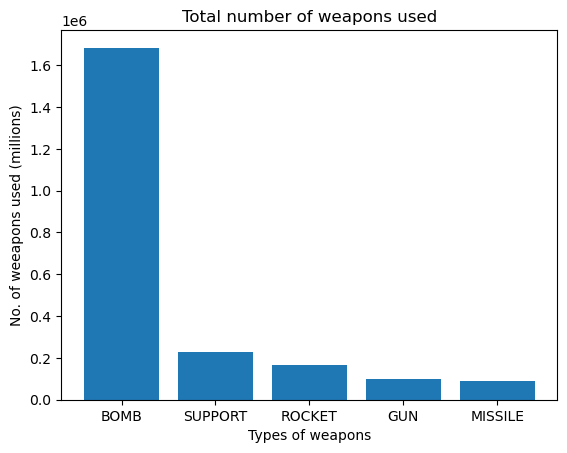

In [7]:
weapon_class_count = weapons.groupby('WEAPON_CLASS', sort=True)['WEAPON_COUNT'].sum()
weapon_class_count = weapon_class_count.sort_values(ascending=False)
fig, ax = plt.subplots()
ax.bar(weapon_class_count.index, weapon_class_count.values)
ax.set_title(label="Total number of weapons used")
ax.set_xlabel(xlabel="Types of weapons")
ax.set_ylabel(ylabel="No. of weeapons used (millions)")

### Checking out weapons in used in operations

In [8]:
operations['WEAPONTYPECLASS'].unique() # Weapon class is not available in operations data

array([nan])

In [9]:
weapon_in_operations = operations['WEAPONTYPE'].unique() # At least weapon type is available
print(f"There are {len(weapon_in_operations)} types of weapon used")
print(weapon_in_operations[:5])

There are 295 types of weapon used
[nan 'BLU27 FIRE BOMB (750)' 'MK 82 GP BOMB (500) LD' 'CARGO (TONS)'
 'CBU24 AN PR/MT (BLU26)']


### We will try to mark WEAPONTYPECLASS using 'weapons' dataframe

In [10]:
weapon_type_and_class = weapons[['WEAPONTYPE', 'WEAPON_CLASS']]
weapon_type_and_class.head(5)

,WEAPONTYPE,WEAPON_CLASS
0,100 GP,BOMB
1,1000 G,BOMB
2,1000LB GP M-65,BOMB
3,1000LB MK-83,BOMB
4,1000LB SAP M59,BOMB


In [11]:
operations = operations.merge(weapon_type_and_class, on='WEAPONTYPE', how='left')

In [12]:
len(operations['WEAPON_CLASS'].notnull()) / len(operations['WEAPONTYPE'].notnull()) # verifies that all weapon type can be found in weapons

1.0

### Should we only use data with coordinates?
Since we are analyzing REGIONS with high UXO risk it is important that we need to know the locations so maybe we will drop all samples without the coordinate

In [13]:
total_entries = len(operations)
available_ratio = operations[operations != 'NaN'].count() / total_entries * 100
available_ratio.sort_values(ascending=False)

Unnamed: 0              100.000000
THOR_DATA_VIET_ID       100.000000
ADDITIONALINFO          100.000000
ID                      100.000000
WEAPONTYPEWEIGHT        100.000000
MFUNC_DESC_CLASS        100.000000
NUMWEAPONSJETTISONED    100.000000
NUMOFACFT               100.000000
NUMWEAPONSDELIVERED     100.000000
FLTHOURS                100.000000
NUMWEAPONSRETURNED      100.000000
WEAPONSLOADEDWEIGHT     100.000000
VALID_AIRCRAFT_ROOT     100.000000
SOURCERECORD            100.000000
SOURCEID                100.000000
MSNDATE                 100.000000
AIRCRAFT_ORIGINAL        99.989680
AIRCRAFT_ROOT            99.989680
UNIT                     99.989444
MILSERVICE               99.930434
COUNTRYFLYINGMISSION     99.922598
TAKEOFFLOCATION          99.893564
MISSIONID                99.664484
TIMEOFFTARGET            99.434119
TIMEONTARGET             99.434119
MFUNC                    97.835075
MFUNC_DESC               97.757759
PERIODOFDAY              95.722779
TGTCOUNTRY          

### We can see that 75% of the samples have  coordinate data, we should investigate why the other 25% samples don't have coordinate data

In [14]:
operations_with_coords = operations[operations['TGTLONDDD_DDD_WGS84'].notnull()]
operations_wihtout_coords = operations[operations['TGTLONDDD_DDD_WGS84'].isnull()]

In [19]:
import pandas as pd

def TVD(df1, df2, column):
    dist1 = df1[column].value_counts(normalize=True)
    dist2 = df2[column].value_counts(normalize=True)

    all_categories = set(dist1.index).union(dist2.index)

    tvd = 0.5 * sum(abs(dist1.get(cat, 0) - dist2.get(cat, 0)) for cat in all_categories)
    return tvd

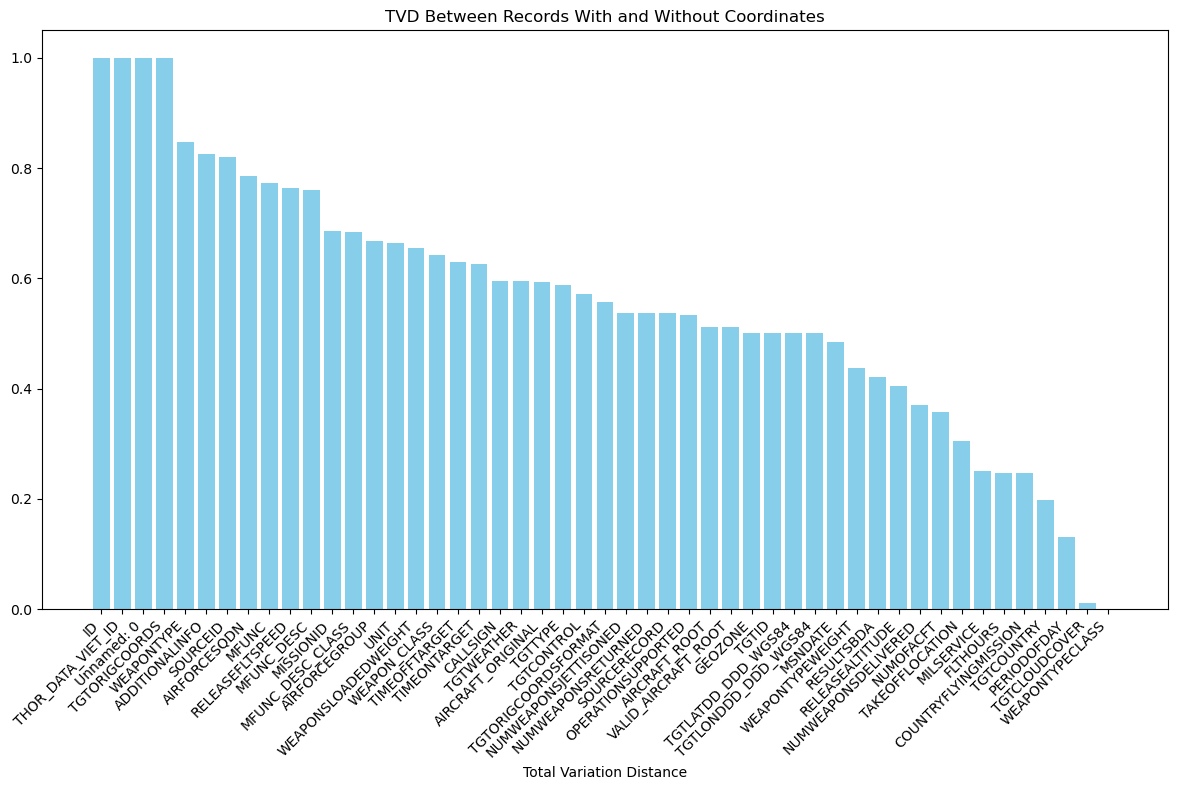

In [20]:
import matplotlib.pyplot as plt

# Store results in a list
tvd_scores = []

for col in operations.columns:
    try:
        score = TVD(operations_with_coords, operations_wihtout_coords, col)
        tvd_scores.append((col, score))
    except Exception as e:
        # Skip columns that can't be evaluated (e.g., unhashable types)
        continue

# Convert to DataFrame for easy plotting
tvd_df = pd.DataFrame(tvd_scores, columns=['Column', 'TVD']).sort_values(by='TVD', ascending=False)

# Plot
plt.figure(figsize=(12, 8))

plt.bar(tvd_df['Column'], tvd_df['TVD'], color='skyblue')
plt.xlabel('Total Variation Distance')
plt.title('TVD Between Records With and Without Coordinates')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### We can see that the majority of TVD distance is over 40%
- Values like IDs have high uniqueness and doesn't contribute anything to TVD comparison so we will not include that in the mean TVD.
- Values like coordinate also behave like ID but are necessary, so instead of using raw coordinates, we use the GEOZONE feature.

In [56]:
scores = []
for col, score in tvd_scores:
    if col in ['ID', 'THOR_DATA_VIET_ID', 'Unamed: 0', 'TGTORIGCOORDS', 'TGTLAT_DDD_WSG84', 'TGT_LONDDD_DDD_WSG84']:
        continue
    else:
        scores.append(score)
print(f"The mean TVD score is: {np.mean(scores)}")

The mean TVD score is: 0.5296433245067483


# 4. Finding the dud rate of explosives
Dud rate is the probability of an explosive not exploding when deployed. It is said that the dud rate of bombs range between 10% to 40% but we have no credible source for this. We need to figure out how to determine the dud rate. Luckily, we have sample data from UXO diffusal from Quảng Trị Mine Action Center (QTMAC) publicly available. 

Quang Tri Mine action center: https://qtmac.vn/vi/du-lieu-va-so-lieu/ra-pha-bom-min

In [16]:
qtmac = pd.read_csv('data/qtmac_data.csv')

In [17]:
qtmac.head()

,location,weapon_class,weapon_count
0,hai lang,cluster bomb,49500
1,hai lang,bomb and carpet bomb,277
2,hai lang,mortar,12002
3,hai lang,rocket,950
4,hai lang,firearm munition,16534
